In [313]:
import numpy as np

class KeerthiSmo:
    def __init__(self, data, class_labels, C, tolerance=1e-3, eps=1e-8, maxiter=1000):
        self.x = np.asarray(data, dtype=np.float64)
        self.y = np.asarray(class_labels, dtype=np.float64).reshape(-1, 1)
        self.N = self.y.shape[0]
        self.C = np.float64(C)
        self.tolerance = np.float64(tolerance)
        self.eps = np.float64(eps)
        self.maxiter = maxiter

        # Инициализация параметров с указанием точности
        self.alpha = np.zeros((self.N, 1), dtype=np.float64)
        self.b = np.float64(0)
        self.kernel_evaluation = 0

        # Параметры ядра
        self.kernel_type = 'linear'
        self.degree = 2
        self.sigma = np.float64(1.0)

        # Кэширование значений
        self.Fcache = np.zeros((self.N, 1), dtype=np.float64)
        self.b_up = np.float64(-1.0)
        self.b_down = np.float64(1.0)
        self.i_up = np.argmax(self.y == 1)
        self.i_down = np.argmax(self.y == -1)

        # Инициализация кэша
        self.Fcache[self.i_up] = np.float64(-1.0)
        self.Fcache[self.i_down] = np.float64(1.0)

        self.is_support_vector = np.zeros((self.N, 1), dtype=bool)
        self.alpha_history = np.zeros((self.N, maxiter), dtype=np.float64)
        self.iter = 0

    def kernel(self, x1, x2):
        self.kernel_evaluation += 1
        x1 = np.asarray(x1, dtype=np.float64)
        x2 = np.asarray(x2, dtype=np.float64)
        
        if self.kernel_type == 'gaussian':
            return np.exp(-np.linalg.norm(x2 - x1)**2 * self.sigma)
        elif self.kernel_type == 'polynomial':
            return (1.0 + np.dot(x1, x2.T))**self.degree
        else:  # linear
            return np.dot(x1, x2.T)

    def set_kernel(self, kernel_type, **kwargs):
        self.kernel_type = kernel_type
        if kernel_type == 'gaussian':
            self.sigma = np.float64(kwargs.get('sigma', self.sigma))
        elif kernel_type == 'polynomial':
            self.degree = int(kwargs.get('degree', self.degree))

    def calculate_boundaries(self, i1, i2, alpha_old1, alpha_old2):
        y1 = self.y[i1].item()
        y2 = self.y[i2].item()
        
        if y1 != y2:
            L = np.maximum(0.0, alpha_old2 - alpha_old1)
            H = np.minimum(self.C, self.C + alpha_old2 - alpha_old1)
        else:
            L = np.maximum(0.0, alpha_old2 + alpha_old1 - self.C)
            H = np.minimum(self.C, alpha_old2 + alpha_old1)
        return L.astype(np.float64), H.astype(np.float64)

    def calc_Fi(self, i):
        # Векторизованное вычисление ядра
        K = np.array([self.kernel(self.x[i], xk) for xk in self.x], dtype=np.float64)
        return np.sum(self.alpha * self.y * K.reshape(-1, 1)) - self.y[i]

    def examine_example(self, i1):
        i1 = int(i1)
        alpha1 = self.alpha[i1].item()
        y1 = self.y[i1].item()
        
        if 0.0 < alpha1 < self.C:
            F1 = self.Fcache[i1].item()
        else:
            F1 = self.calc_Fi(i1).item()
            self.Fcache[i1] = F1
            
            # Обновление границ с контролем типов
            if (alpha1 == 0.0 and y1 == 1.0) or (alpha1 == self.C and y1 == -1.0):
                if F1 < self.b_up:
                    self.b_up = np.float64(F1)
                    self.i_up = i1
            elif (alpha1 == self.C and y1 == 1.0) or (alpha1 == 0.0 and y1 == -1.0):
                if F1 > self.b_down:
                    self.b_down = np.float64(F1)
                    self.i_down = i1

        optimal = True
        i2 = -1
        
        # Проверка условий оптимальности с учетом численной стабильности
        if ((y1 == 1.0 and alpha1 < self.C) or 
            (y1 == -1.0 and alpha1 > 0.0)):
            if self.b_down - F1 > self.tolerance + 1e-10:
                optimal = False
                i2 = self.i_down
                
        if ((y1 == -1.0 and alpha1 < self.C) or 
            (y1 == 1.0 and alpha1 > 0.0)):
            if F1 - self.b_up > self.tolerance + 1e-10:
                optimal = False
                i2 = self.i_up
                
        if optimal:
            return 0

        if 0.0 < alpha1 < self.C:
            if self.b_down - F1 > F1 - self.b_up + 1e-10:
                i2 = self.i_down
            else:
                i2 = self.i_up
                
        return self.take_step(i1, i2)

    def take_step(self, i1, i2):
        if i1 == i2:
            return 0

        y1 = self.y[i1].item()
        y2 = self.y[i2].item()
        s = y1 * y2
        
        alpha_old1 = self.alpha[i1].copy()
        alpha_old2 = self.alpha[i2].copy()
        
        # Вычисление F с контролем точности
        F1 = self.Fcache[i1].item() if 0.0 < alpha_old1 < self.C else self.calc_Fi(i1).item()
        F2 = self.Fcache[i2].item() if 0.0 < alpha_old2 < self.C else self.calc_Fi(i2).item()

        L, H = self.calculate_boundaries(i1, i2, alpha_old1, alpha_old2)
        if L >= H - 1e-10:
            return 0

        # Вычисление ядер с повышенной точностью
        k11 = np.float64(self.kernel(self.x[i1], self.x[i1]))
        k12 = np.float64(self.kernel(self.x[i1], self.x[i2]))
        k22 = np.float64(self.kernel(self.x[i2], self.x[i2]))
        eta = np.float64(2.0 * k12 - k11 - k22)
        
        # Вычисление нового alpha2 с контролем численной стабильности
        if eta < -1e-10:
            alpha2_new = alpha_old2 + y2 * (F2 - F1) / eta
            alpha2_new = np.clip(alpha2_new, L, H)
        else:
            c1 = eta / 2.0
            c2 = y2 * (F1 - F2) - eta * alpha_old2
            L_obj = c1 * L**2 + c2 * L
            H_obj = c1 * H**2 + c2 * H
            alpha2_new = L if L_obj > H_obj + 1e-10 else H if H_obj > L_obj + 1e-10 else alpha_old2
            
        if np.abs(alpha2_new - alpha_old2) < self.eps:
            return 0

        # Обновление alpha1 с контролем границ
        alpha1_new = alpha_old1 + s * (alpha_old2 - alpha2_new)
        
        # Коррекция выхода за границы
        if alpha1_new < 0.0:
            delta = s * alpha1_new
            alpha2_new -= delta
            alpha1_new = 0.0
        elif alpha1_new > self.C:
            delta = alpha1_new - self.C
            alpha2_new += s * delta
            alpha1_new = self.C

        # Финализация значений с округлением
        alpha1_new = np.clip(alpha1_new, 0.0, self.C)
        alpha2_new = np.clip(alpha2_new, 0.0, self.C)
        
        # Применение изменений
        delta_alpha1 = alpha1_new - alpha_old1
        delta_alpha2 = alpha2_new - alpha_old2
        
        self.alpha[i1] = alpha1_new
        self.alpha[i2] = alpha2_new

        # Векторизованное обновление Fcache
        K_i1 = np.array([self.kernel(self.x[i1], xk) for xk in self.x], dtype=np.float64)
        K_i2 = np.array([self.kernel(self.x[i2], xk) for xk in self.x], dtype=np.float64)
        
        self.Fcache += y1 * delta_alpha1 * K_i1.reshape(-1, 1)
        self.Fcache += y2 * delta_alpha2 * K_i2.reshape(-1, 1)

        # Обновление границ
        self.update_bounds(i1)
        self.update_bounds(i2)
        
        return 1

    def update_bounds(self, i):
        alpha_i = self.alpha[i].item()
        y_i = self.y[i].item()
        F_i = self.Fcache[i].item()
        
        if (alpha_i == 0.0 and y_i == 1.0) or (alpha_i == self.C and y_i == -1.0):
            if F_i < self.b_up:
                self.b_up = np.float64(F_i)
                self.i_up = i
        elif (alpha_i == self.C and y_i == 1.0) or (alpha_i == 0.0 and y_i == -1.0):
            if F_i > self.b_down:
                self.b_down = np.float64(F_i)
                self.i_down = i

        # Поиск оптимальных границ среди всех support vectors
        mask = (self.alpha > 0.0) & (self.alpha < self.C)
        if np.any(mask):
            min_F = np.min(self.Fcache[mask])
            max_F = np.max(self.Fcache[mask])
            
            if min_F < self.b_up:
                self.b_up = np.float64(min_F)
                self.i_up = np.argmin(self.Fcache[mask])
                
            if max_F > self.b_down:
                self.b_down = np.float64(max_F)
                self.i_down = np.argmax(self.Fcache[mask])

    def train(self):
        num_changed = 0
        examine_all = True
        converged = False
        
        while (num_changed > 0 or examine_all) and self.iter < self.maxiter and not converged:
            num_changed = 0
            self.iter += 1
            
            if examine_all:
                for i1 in range(self.N):
                    num_changed += self.examine_example(i1)
            else:
                for i1 in range(self.N):
                    if 0.0 < self.alpha[i1].item() < self.C:
                        num_changed += self.examine_example(i1)
                    if self.b_up > self.b_down - self.tolerance:
                        converged = True
                        break
                        
            examine_all = not examine_all
            self.alpha_history[:, self.iter-1] = self.alpha.flatten()
            
        # Финализация модели
        self.alpha[self.alpha < 1e-10] = 0.0
        self.is_support_vector = (self.alpha > 0.0).flatten()
        
        # Вычисление смещения с повышенной точностью
        sv_indices = np.where(self.is_support_vector)[0]
        b_list = []
        for i in sv_indices:
            K = np.array([self.kernel(self.x[i], xk) for xk in self.x], dtype=np.float64)
            b_list.append(self.y[i] - np.sum(self.alpha * self.y * K.reshape(-1, 1)))
            
        self.b = np.mean(b_list, dtype=np.float64) if len(b_list) > 0 else 0.0

    def predict(self, data):
        data = np.asarray(data, dtype=np.float64)
        predictions = []
        for sample in data:
            K = np.array([self.kernel(sample, xk) for xk in self.x], dtype=np.float64)
            pred = np.sum(self.alpha * self.y * K.reshape(-1, 1)) + self.b
            predictions.append(np.sign(pred.item()))
        return np.array(predictions, dtype=np.float64)

In [314]:
import numpy as np

In [315]:
def plot_data(X, y, Z, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', marker='o')
    ax1.set_title("Исходные данные")
    ax1.set_xlabel("Признак 1")
    ax1.set_ylabel("Признак 2")


    ax2.scatter(X[:, 0], X[:, 1], c=Z, cmap=plt.cm.coolwarm, edgecolors='k', marker='o')
    ax2.set_title("Предсказанные классы")
    ax2.set_xlabel("Признак 1")
    ax2.set_ylabel("Признак 2")


    fig.suptitle(title)

    plt.show()


In [316]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.datasets import load_iris

In [317]:
def plot_data(X, y, predictions, title, ax):
    # Создание сетки для разделяющей поверхности
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # Предсказание для точек сетки
    Z = smo.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Отображение разделяющей поверхности
    ax.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.2, 
                colors=['blue', 'gray', 'red'])
    ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
    
    # Отображение точек данных
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, 
               edgecolors='k', s=60)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(title)

In [318]:
iris = load_iris()
X1 = iris.data[iris.target != 2, :2]  # Берем первые два класса и два признака
y1 = iris.target[iris.target != 2]
y1 = np.where(y1 == 0, -1, 1)
X2, y2 = make_circles(random_state=42)
y2 = np.where(y2 == 0, -1, 1)
X3, y3 = make_moons(n_samples=200, noise=0.1, random_state=42)
y3 = np.where(y3 == 0, -1, 1)
datasets = [(X1, y1, 'Iris'), 
            (X2, y2, 'Circles'), 
            (X3, y3, 'Moons')]

In [ ]:
svm_linear = [0.01, 0.05, 1]  # C
svm_gaussian = [(0.01, 0.5), (0.01, 1), (0.03, 2)]  # (C, sigma)
svm_poly = [(0.01, 2), (0.03, 2), (0.01, 3), (0.03, 3)] # (C, degree)

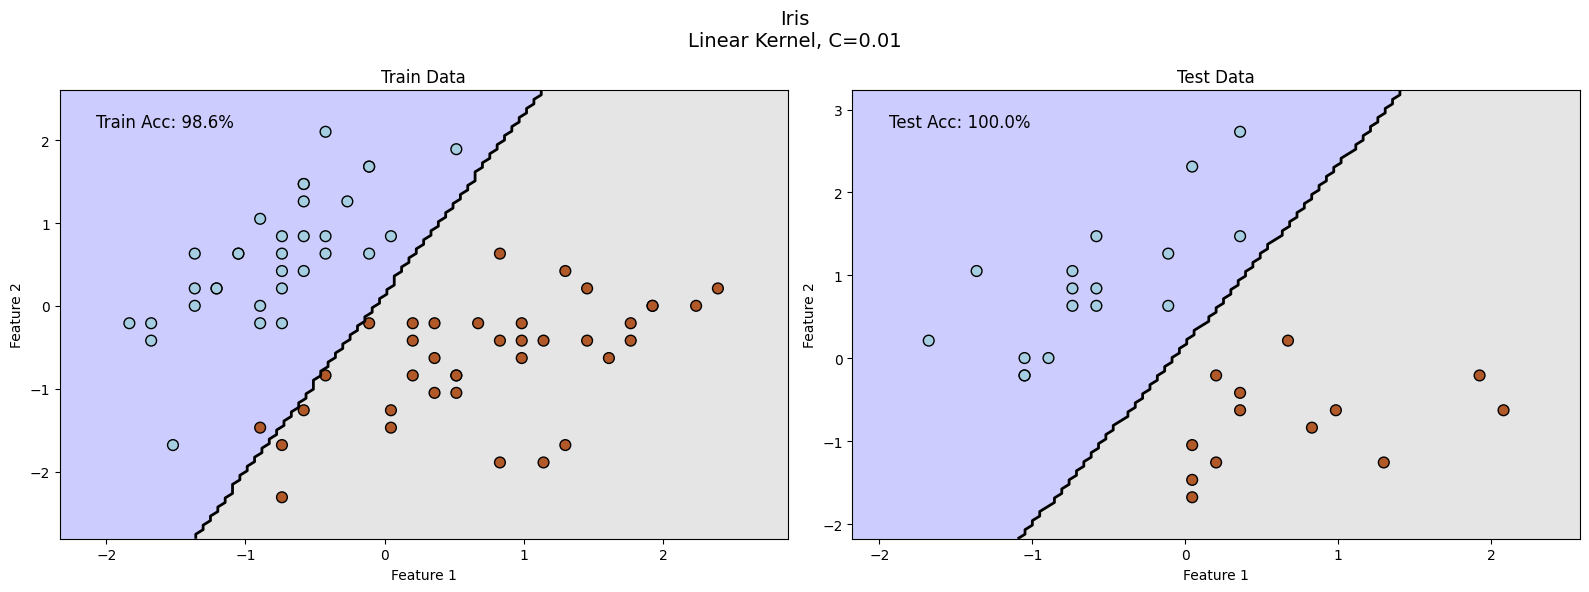

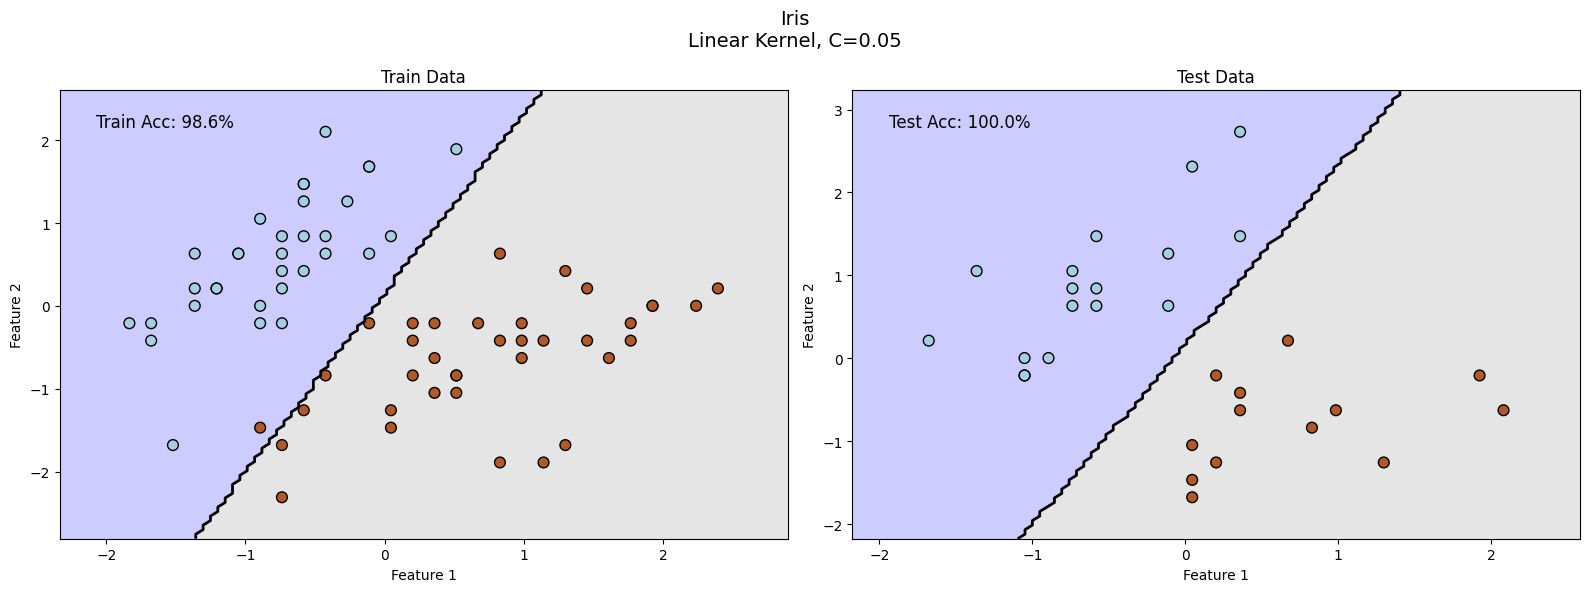

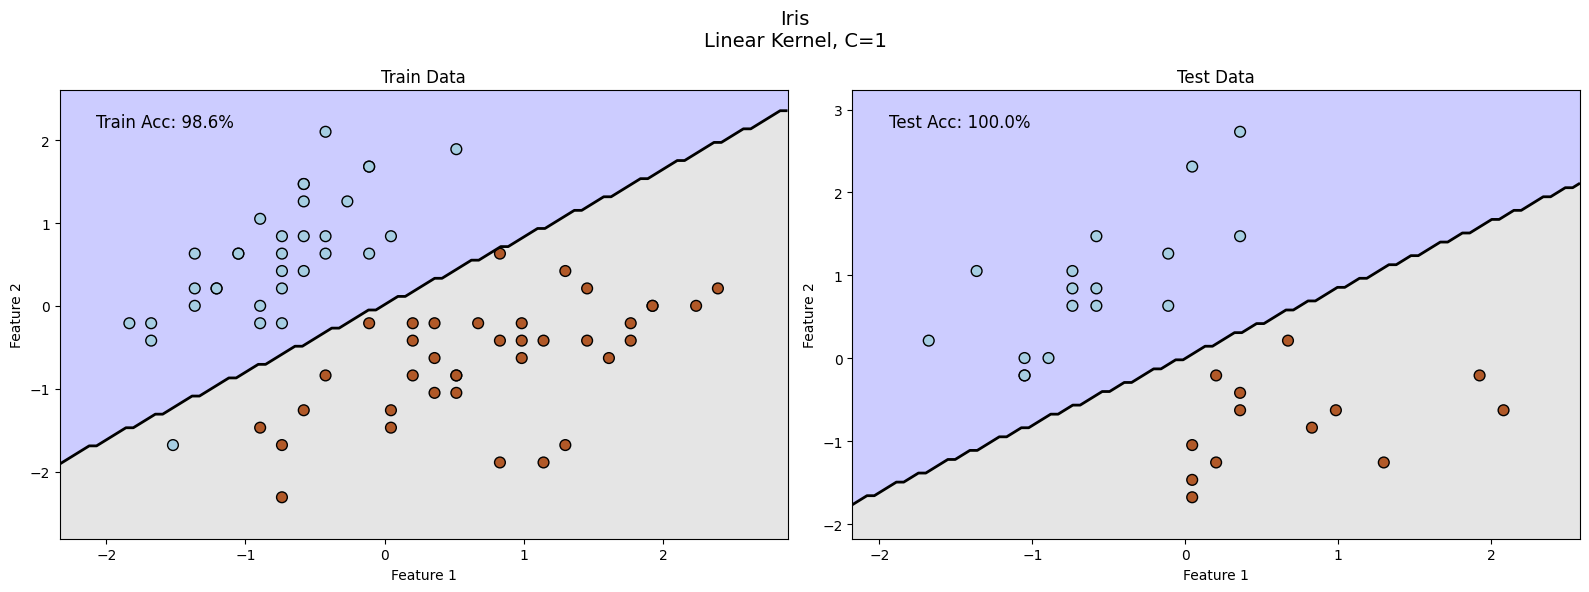

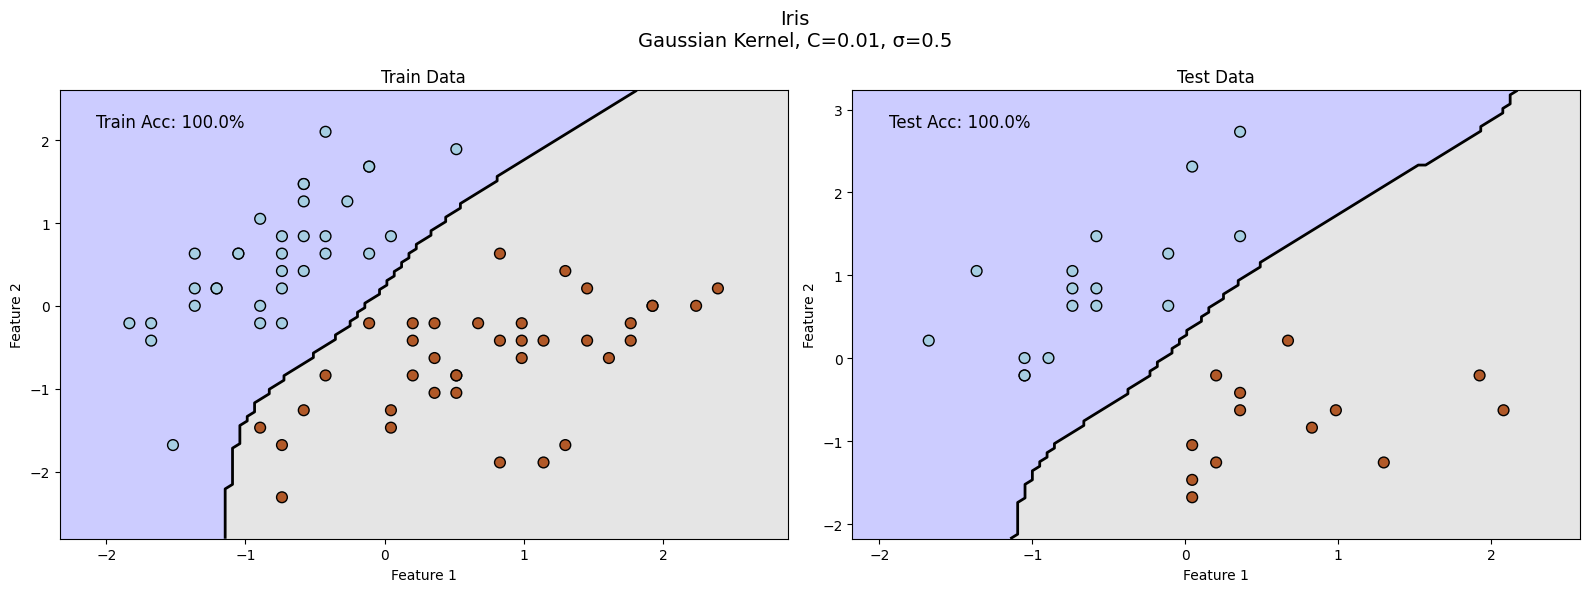

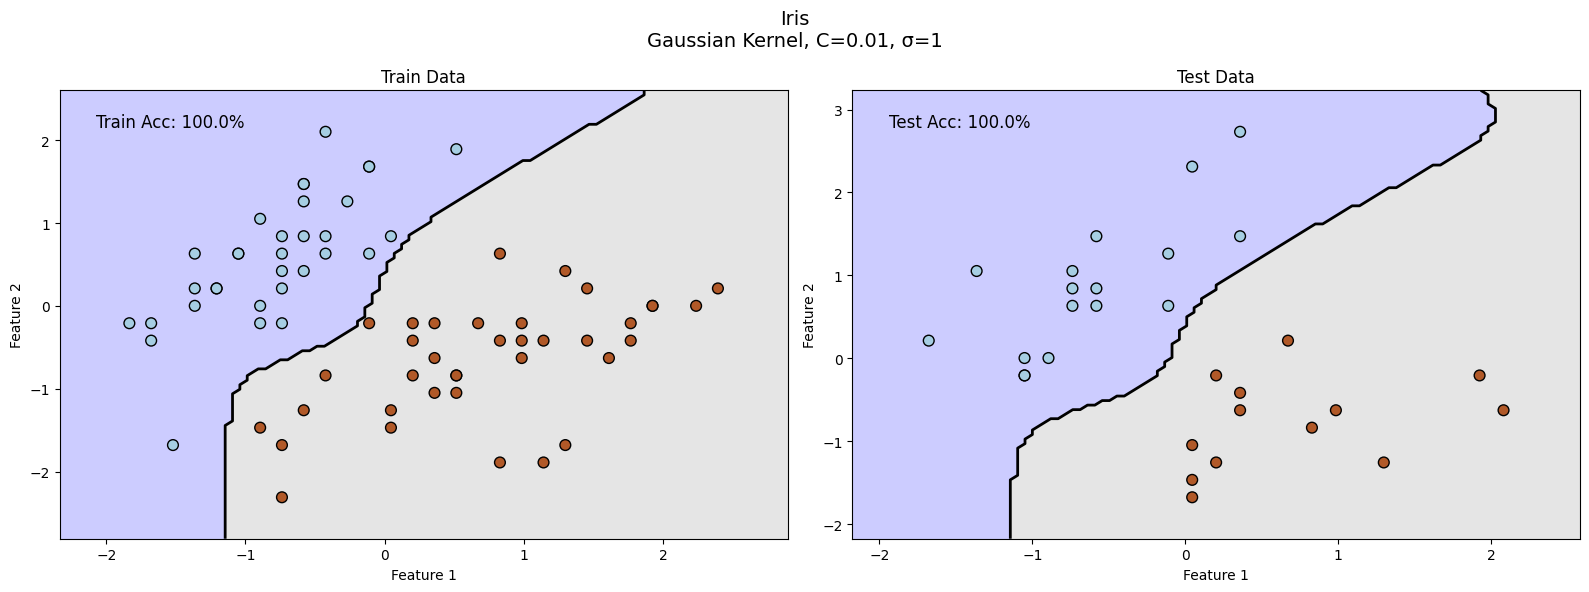

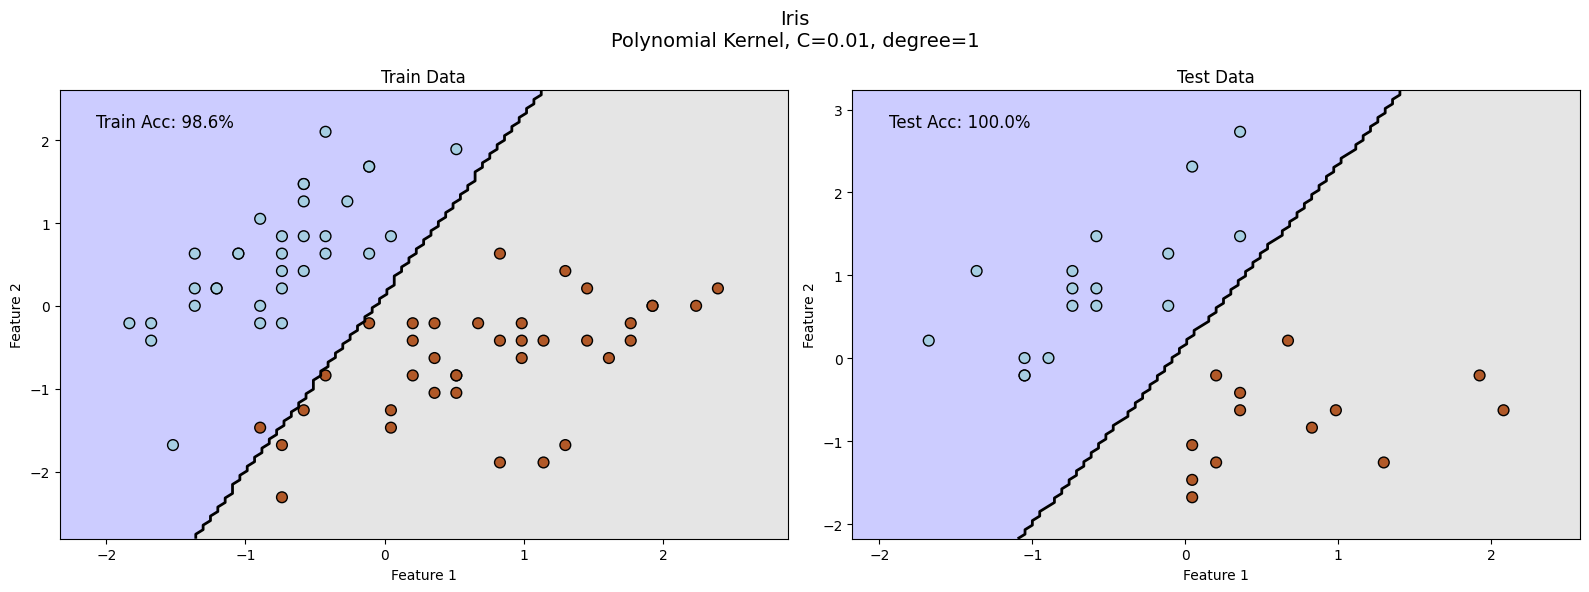

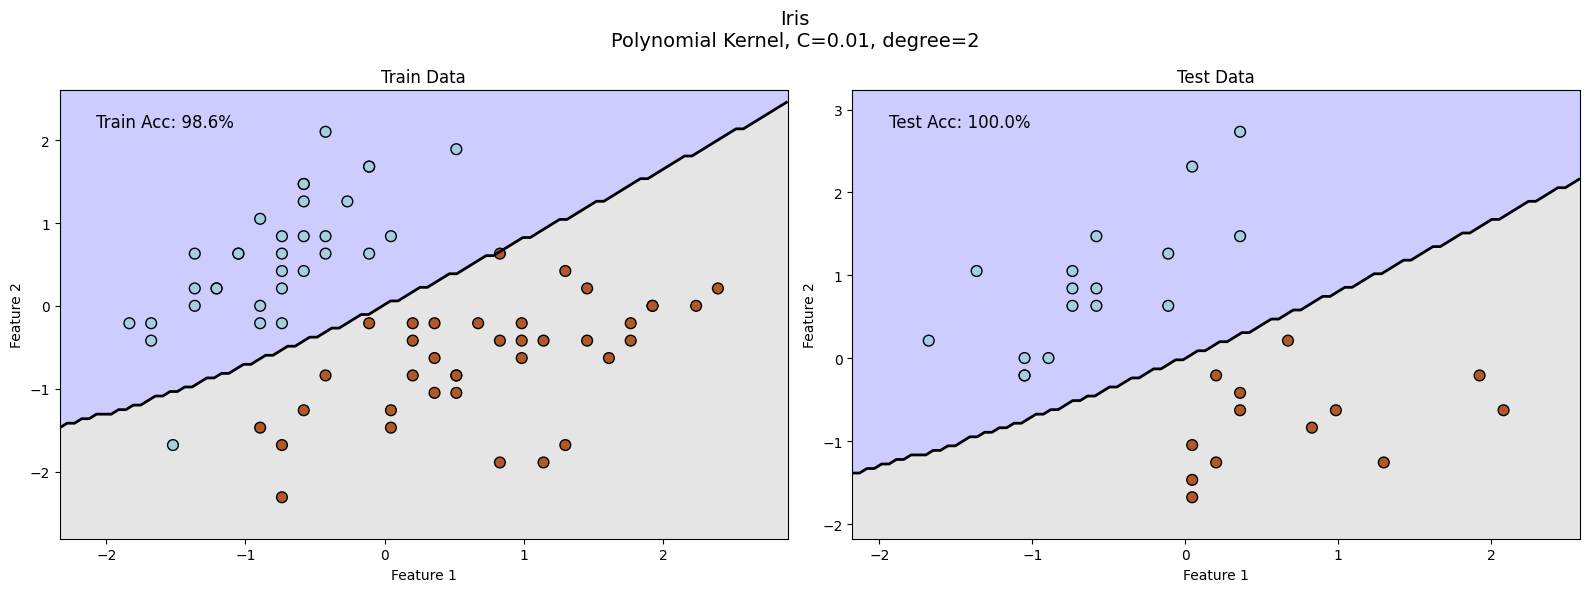

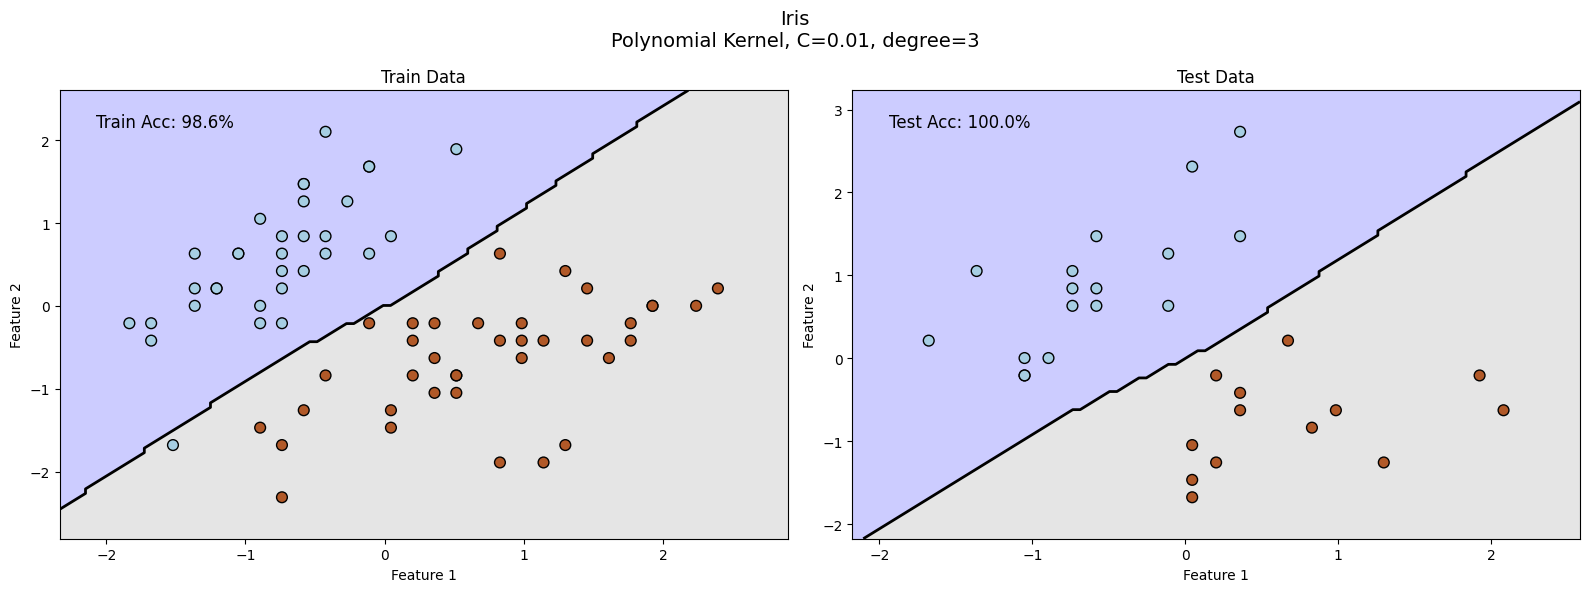

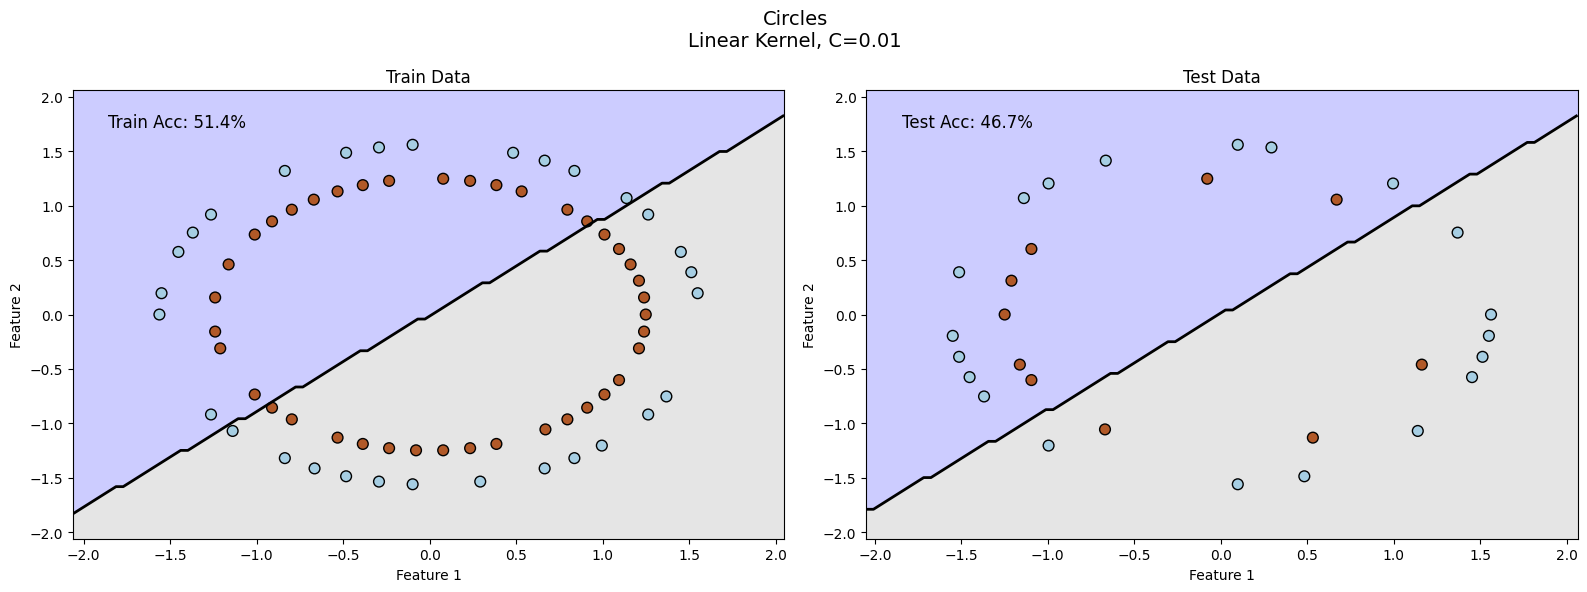

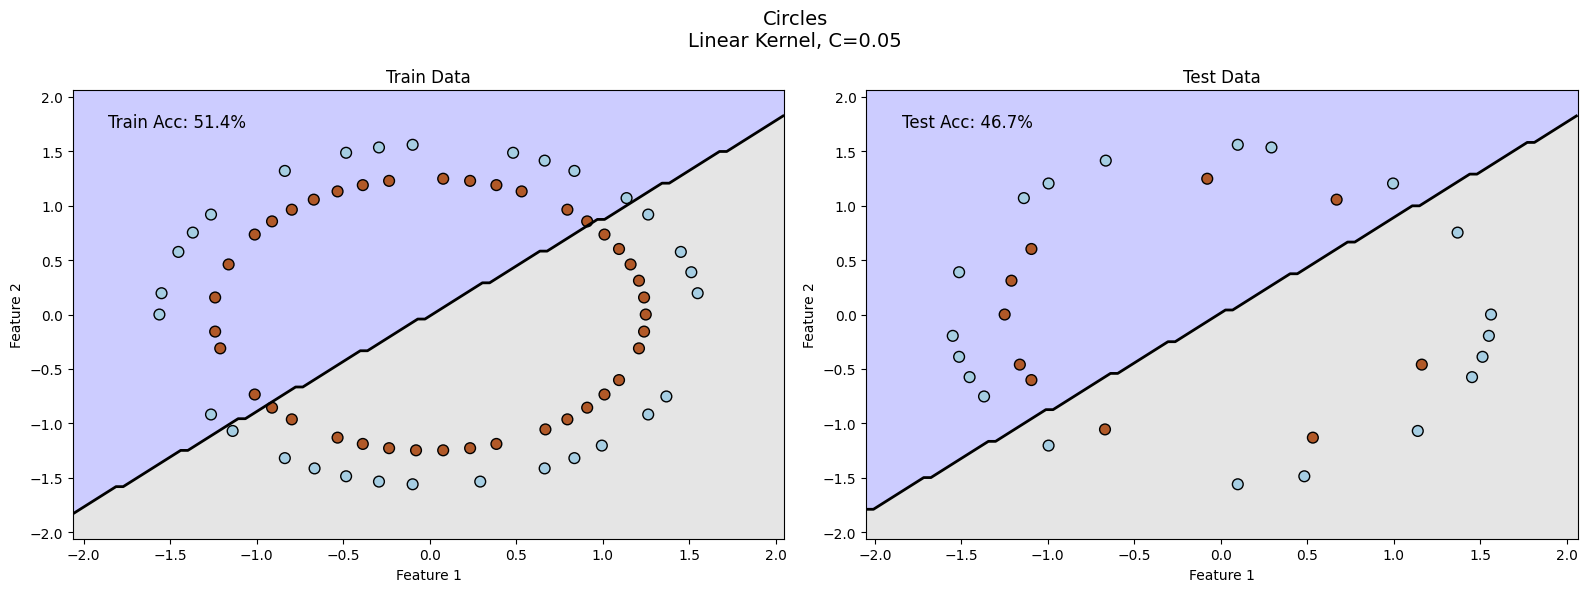

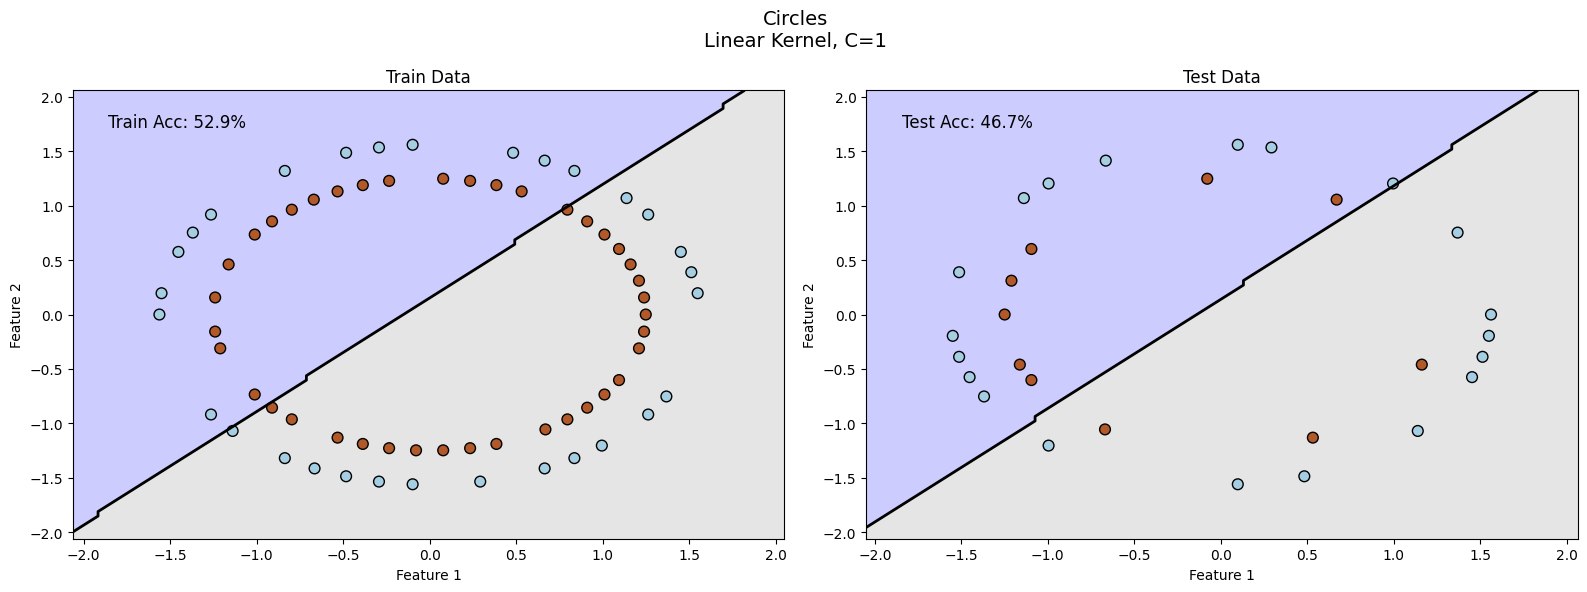

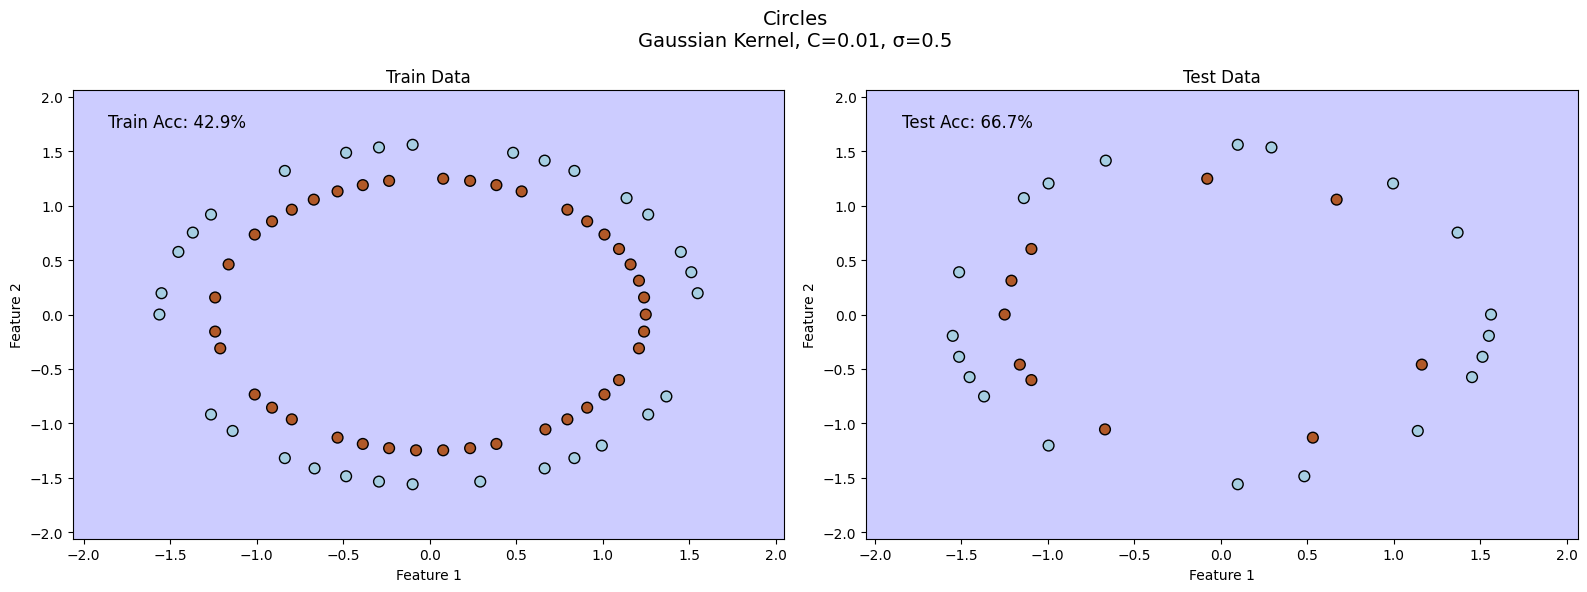

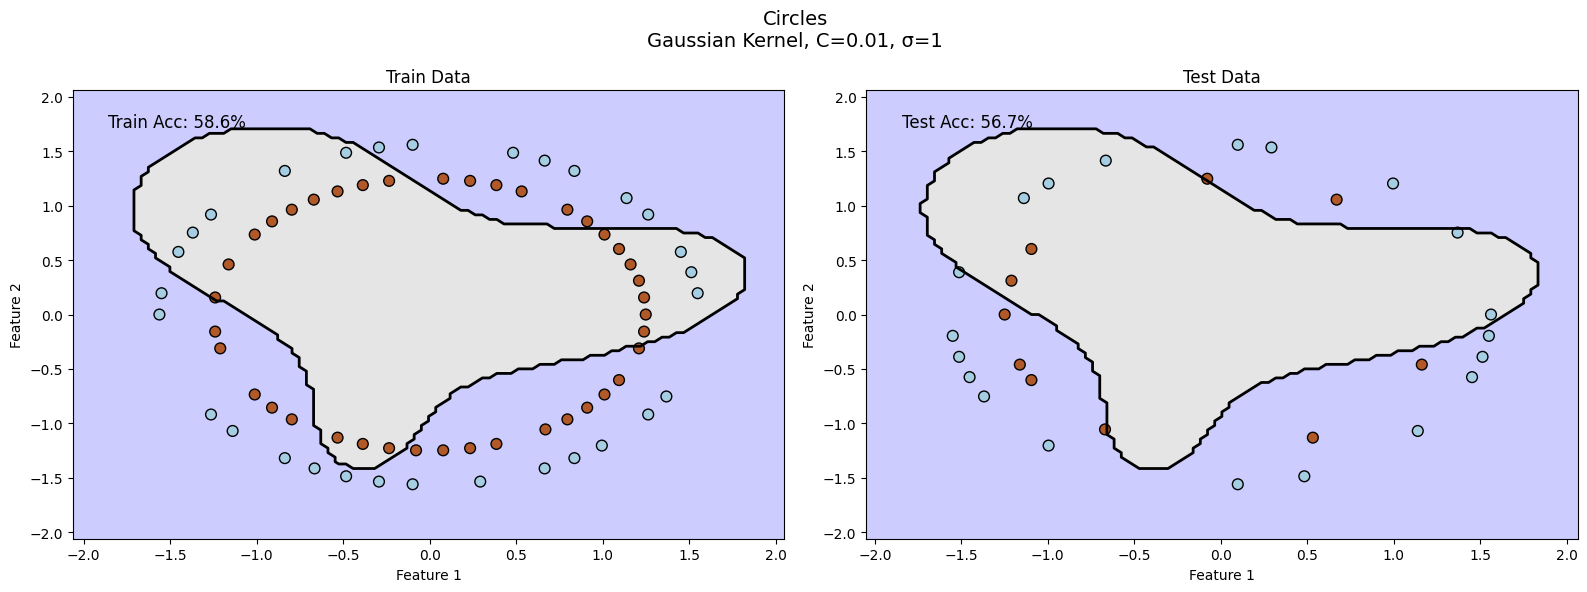

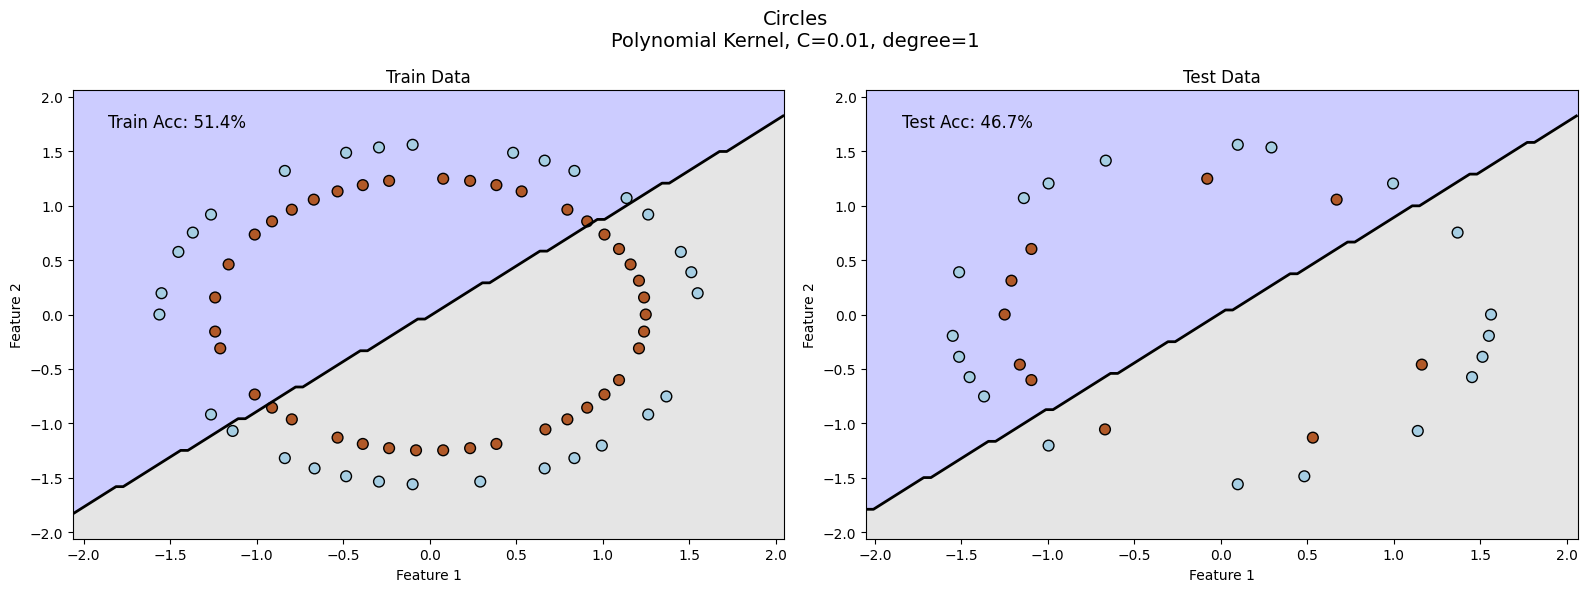

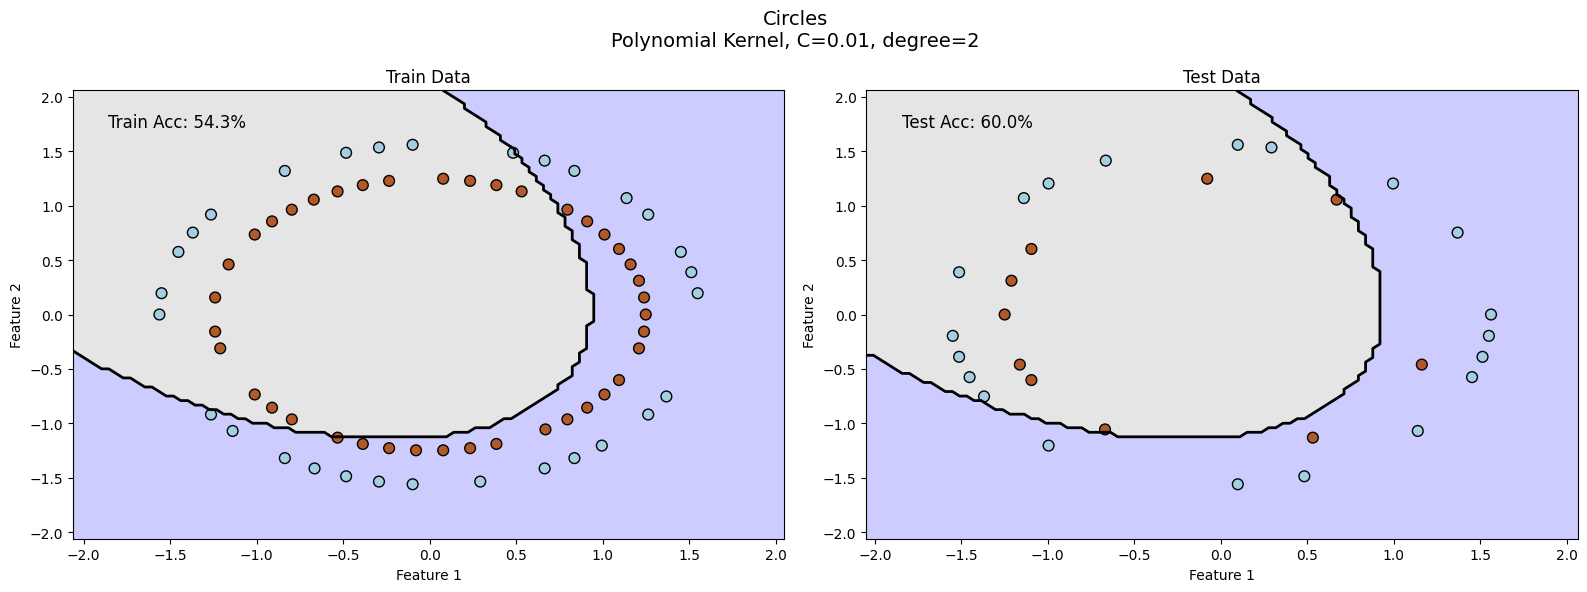

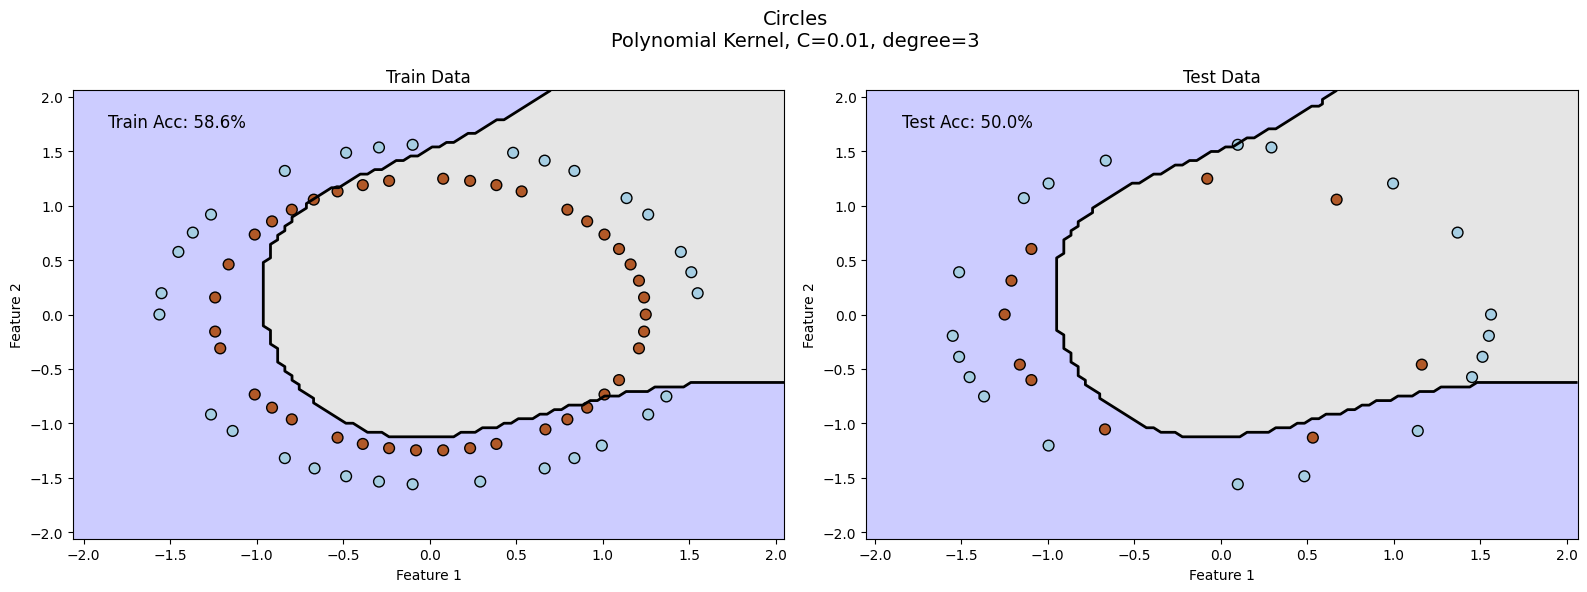

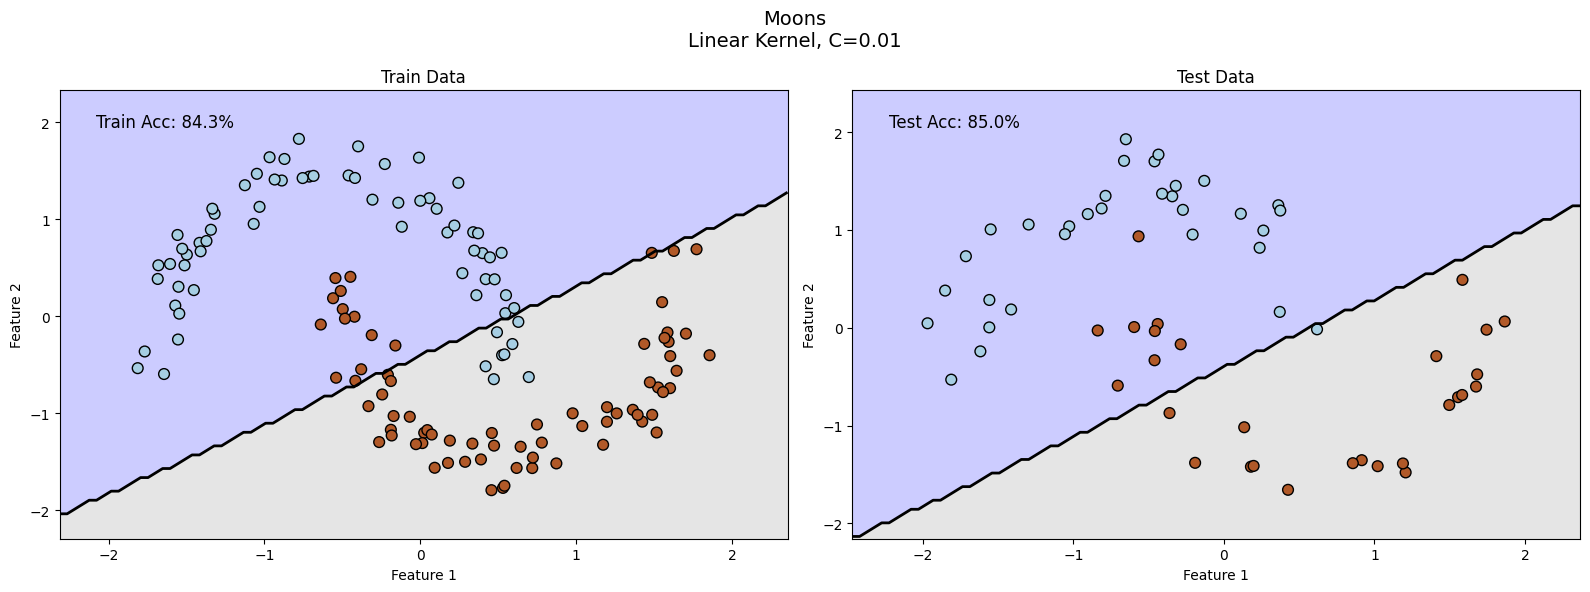

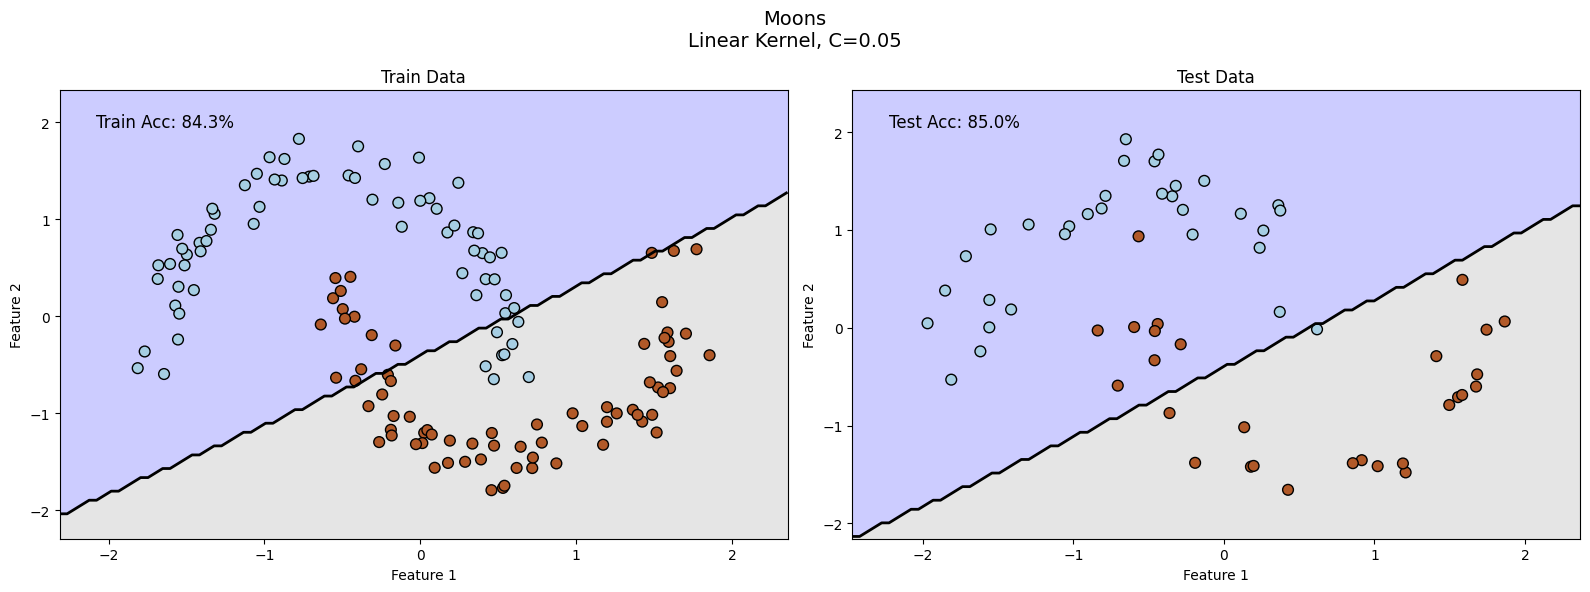

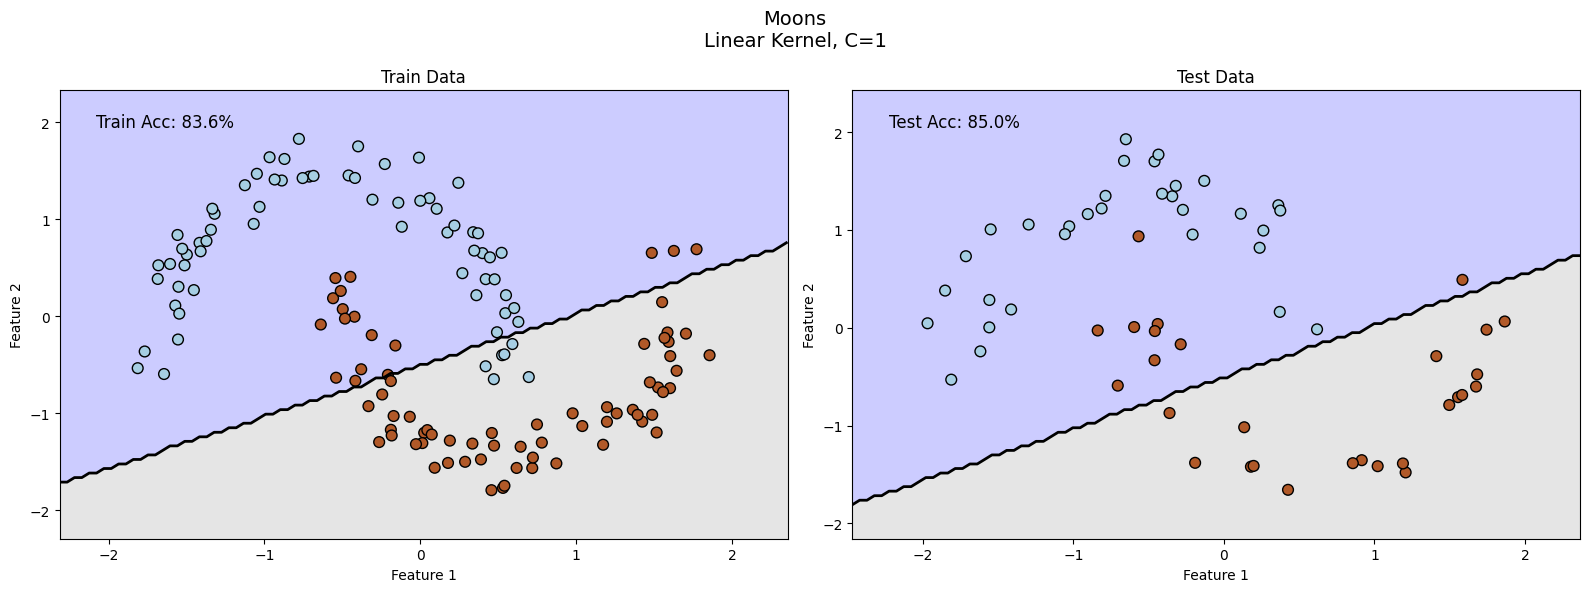

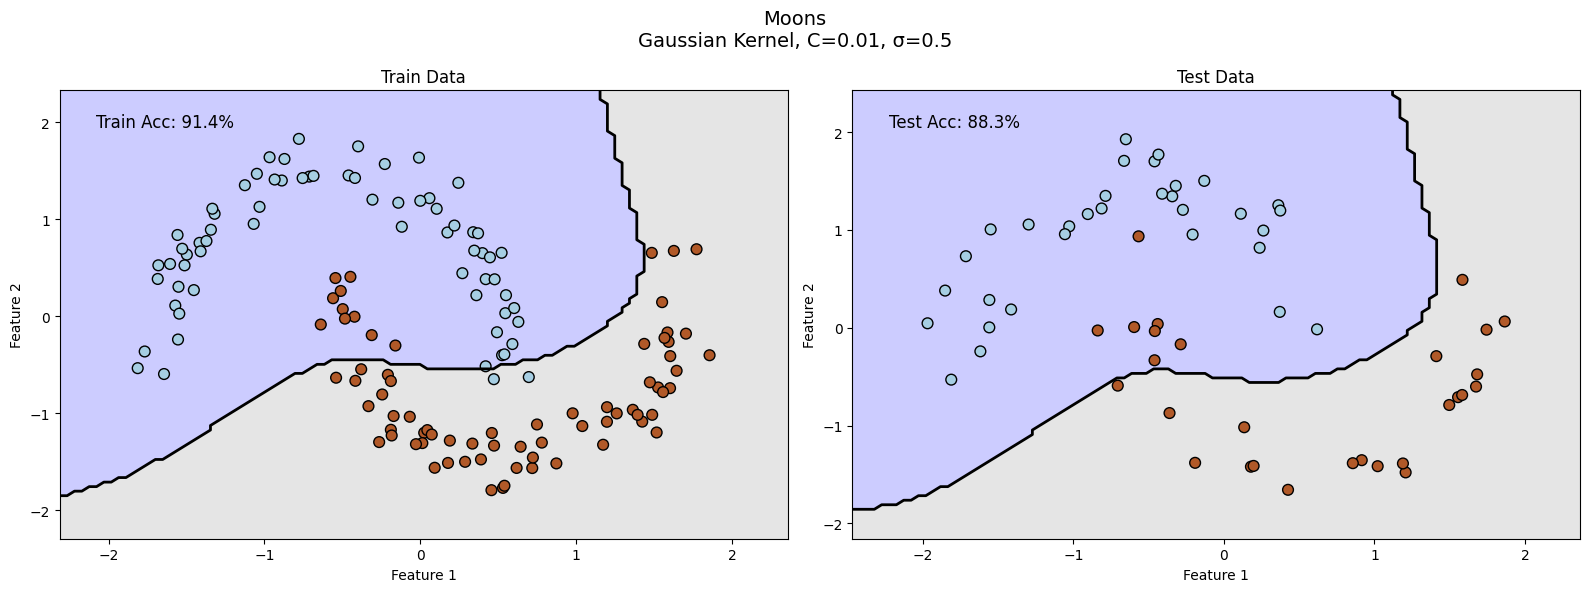

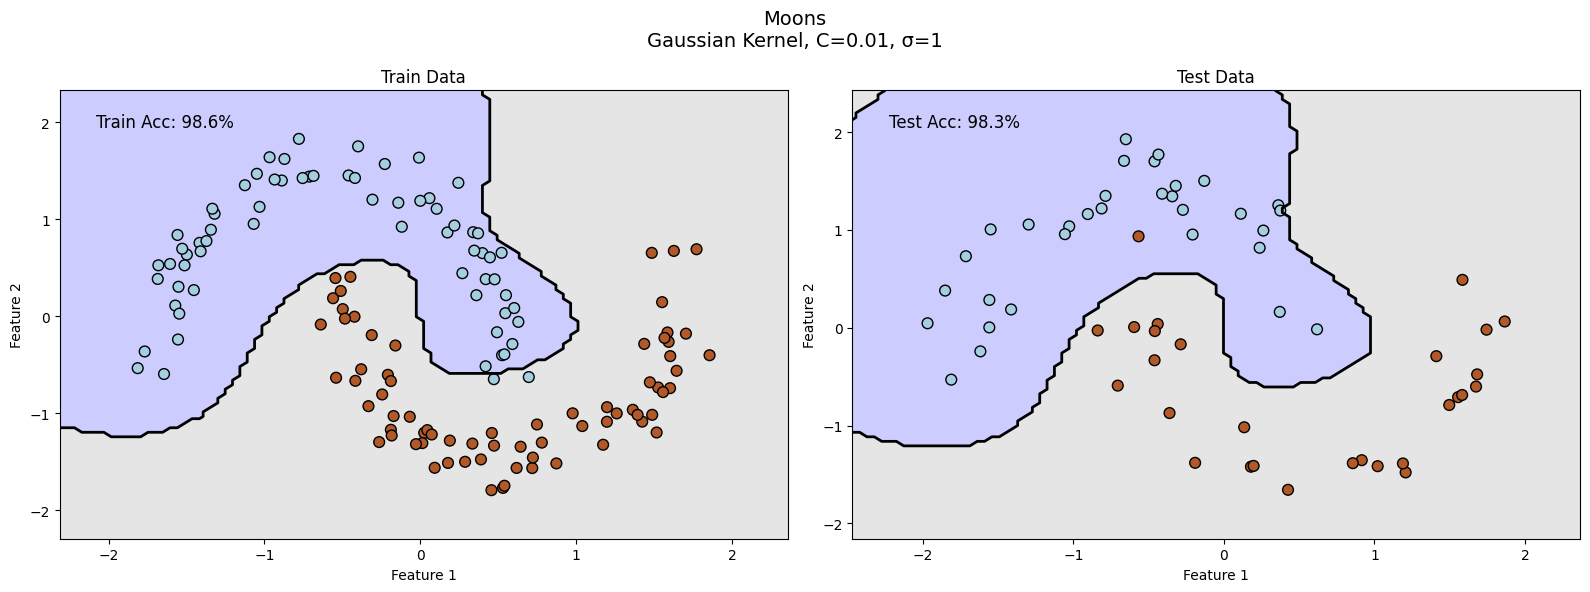

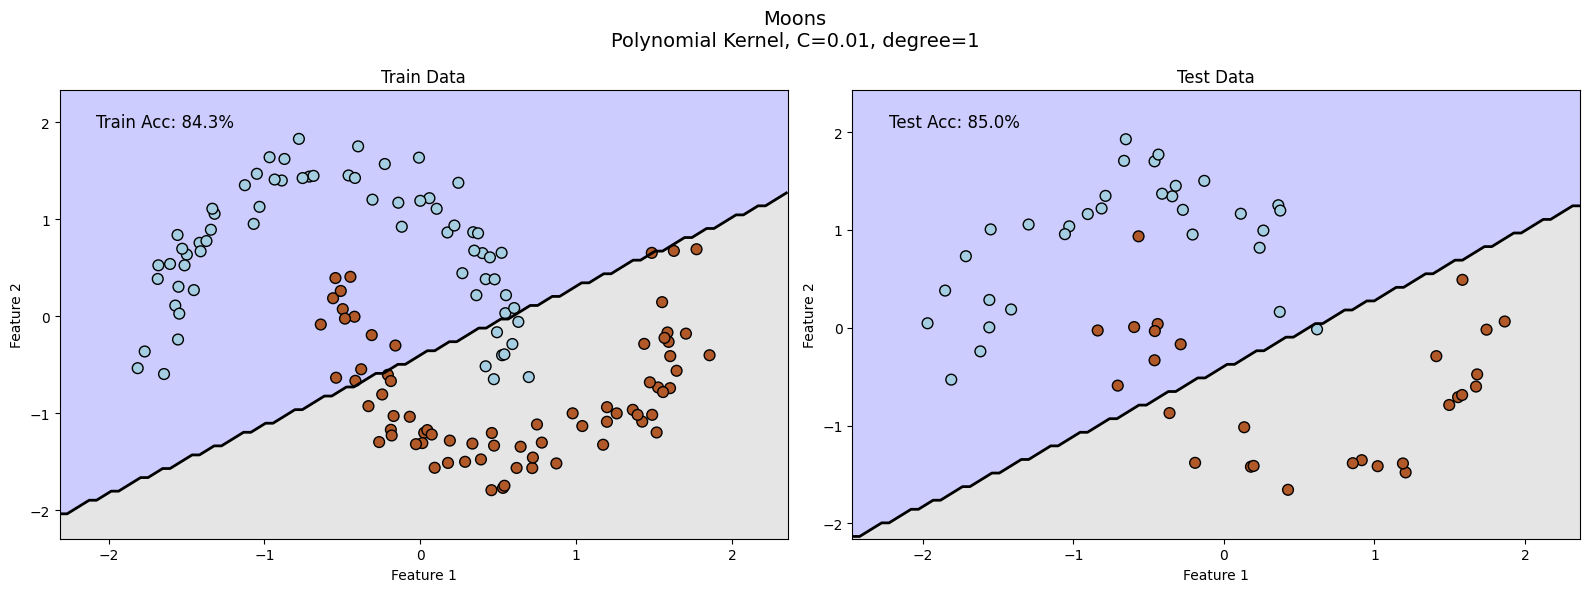

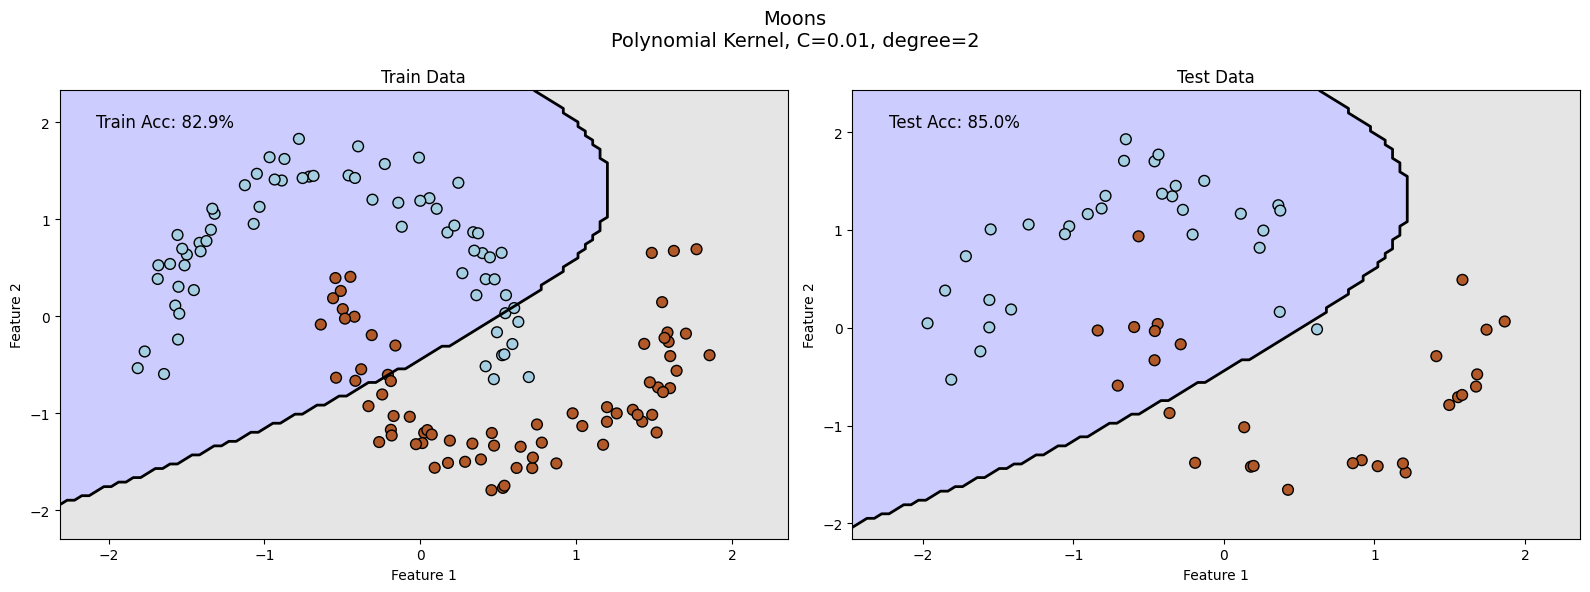

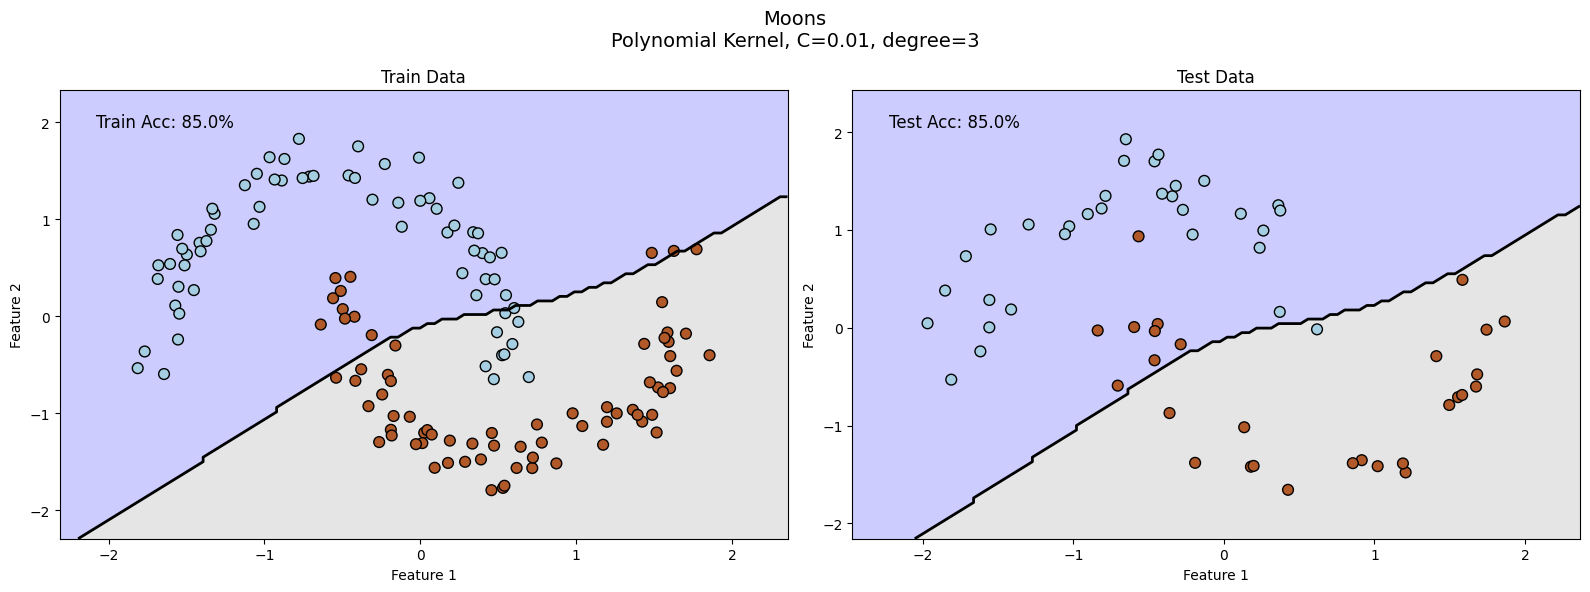

In [320]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

for dataset in datasets:
    X, y, dataset_name = dataset
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Перебор всех конфигураций ядер
    kernel_configs = [
        ('linear', svm_linear),
        ('gaussian', svm_gaussian),
        ('polynomial', svm_poly)
    ]
    
    for kernel_type, params in kernel_configs:
        for param in params:
            if kernel_type == 'linear':
                C = param
                smo = KeerthiSmo(X_train, y_train, C=C)
                title = f"{dataset_name}\nLinear Kernel, C={C}"
            elif kernel_type == 'gaussian':
                C, sigma = param
                smo = KeerthiSmo(X_train, y_train, C=C)
                smo.set_kernel('gaussian', sigma=sigma)
                title = f"{dataset_name}\nGaussian Kernel, C={C}, σ={sigma}"
            elif kernel_type == 'polynomial':
                C, degree = param
                smo = KeerthiSmo(X_train, y_train, C=C)
                smo.set_kernel('polynomial', degree=degree)
                title = f"{dataset_name}\nPolynomial Kernel, C={C}, degree={degree}"
            
            # Обучение модели
            smo.train()
            
            # Создание фигуры с двумя subplots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            fig.suptitle(title, fontsize=14)
            
            # Предсказания и визуализация
            Z_train = smo.predict(X_train)
            Z_test = smo.predict(X_test)
            
            plot_data(X_train, y_train, Z_train, 'Train Data', ax1)
            plot_data(X_test, y_test, Z_test, 'Test Data', ax2)
            
            # Вычисление точности
            train_acc = np.mean(Z_train.flatten() == y_train.flatten())
            test_acc = np.mean(Z_test.flatten() == y_test.flatten())
            
            # Добавление информации о точности
            ax1.text(0.05, 0.95, f"Train Acc: {train_acc*100:.1f}%", 
                    transform=ax1.transAxes, fontsize=12, verticalalignment='top')
            ax2.text(0.05, 0.95, f"Test Acc: {test_acc*100:.1f}%", 
                    transform=ax2.transAxes, fontsize=12, verticalalignment='top')
            
            plt.tight_layout()
            plt.show()